# Analysis procedure for BMI Analysis

## Reading data files and filtering

In [72]:
using CSV, DataFrames, Dates
datadir = "/xdisk/jzhou/aubreyjensen/UKB_48152/pheno/"; 

Start with EUR data: 337,138 subjects.

In [73]:
phenotype_info = CSV.read(datadir * "/EUR_detail.txt", DataFrame)
#data_center = CSV.read(datadir * "/assessment_center.csv", DataFrame)
#phenotype_info = leftjoin(phenotype_info, data_center, on=[:FID=>:FID], makeunique=true)
phenotype_info = rename(phenotype_info,  Symbol("f.eid") => :FID)
phenotype_info = select(phenotype_info, :FID, :DOB, :SEX, :age_2010, :date_init, :age_init, Between(:PC1, :PC10));

## Filtering out samples with missing covariates

Filtering out subjects with missing covariates we need: `SEX`, `age_2010`, `PC1`

Sex. No missing there. 


In [74]:
using StatsBase

In [75]:
#counts(phenotype_info.SEX)

Age at year 2010. This is later used for age at measurement (age_2010 + year_of_measurement - 2010). No missing again. 

In [76]:
count(isnan.(phenotype_info.age_2010))

0

PC1. no missing again. 

In [77]:
count(isnan.(phenotype_info.PC1))

0

## Read in BMI data

In [78]:
BMI_info = CSV.read(datadir * "BMI_combined_pc_ukb.txt", DataFrame)
BMI_info = rename(BMI_info,  Symbol("eid") => :FID)
BMI_info = filter(x -> x.source == "PC", BMI_info)
sort!(BMI_info, [:FID, :event_dt]);

Number of subjects with BMI data: 

In [79]:
length(unique(BMI_info[!, :FID]))

211485

## Join BMI data with phenotypes

Inner join BMI_info and phenotype_info.

In [80]:
BMI_info_joined = innerjoin(BMI_info, phenotype_info, on=[:FID=>:FID], makeunique=true);

Number of subjects:

In [81]:
length(unique(BMI_info_joined.FID))

144443

## Cleaning measurement dates and age at measurements

In [82]:
BMI_info_joined = filter(x -> x.event_dt !== missing, BMI_info_joined);

In [83]:
length(unique(BMI_info_joined.FID))

144418

Obtain year of measurement and age at measurement:

In [84]:
BMI_info_joined.year_of_measurement = map(x ->  Dates.year(x.event_dt), eachrow(BMI_info_joined))

1089259-element Vector{Int64}:
 1997
 2001
 2006
 2007
 2008
 2008
 2008
 2009
 2010
 2011
 2011
 2012
 2013
    ⋮
 2016
 2015
 1991
 1994
 2004
 2005
 2008
 2008
 2008
 2013
 2015
 2015

In [85]:
BMI_info_joined.age_at_measurement = map(x -> x.age_2010 + x.year_of_measurement - 2010, eachrow(BMI_info_joined));

Special meaning for year 1901 1902, and 1903, 2037

https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?tk=68EMKkCB8skqob929k0lJTa0eLbPoYnY157881&id=819


| Date | Meaning |
|:---|:---|
| 1900-01-01 |	Code has no event date |
| 1901-01-01 |	Code has event date before participant's date of birth |
| 1902-02-02 |	Code has event date matching participant's date of birth |
| 1903-03-03 |	Code has event date after participant's date of birth and falls in the same calendar year as date of birth |
| 2037-07-07 |	Code has event date in the future and is presumed to be a place-holder or other system default |

We remove them. 

In [86]:
minimum(BMI_info_joined.age_at_measurement)

-68

In [87]:
maximum(BMI_info_joined.age_at_measurement)

97

In [88]:
yom_map = countmap(BMI_info_joined.year_of_measurement);
for v in sort(yom_map)
    println(v)
end

1902 => 127
1903 => 4
1948 => 1
1956 => 1
1964 => 2
1965 => 2
1966 => 4
1967 => 3
1968 => 2
1969 => 2
1970 => 6
1971 => 2
1972 => 2
1973 => 2
1974 => 3
1975 => 5
1976 => 12
1977 => 7
1978 => 6
1979 => 4
1980 => 12
1981 => 6
1982 => 6
1983 => 35
1984 => 36
1985 => 77
1986 => 152
1987 => 205
1988 => 386
1989 => 933
1990 => 3583
1991 => 5353
1992 => 8197
1993 => 19349
1994 => 16705
1995 => 15538
1996 => 14343
1997 => 12760
1998 => 13190
1999 => 16188
2000 => 17342
2001 => 21762
2002 => 27323
2003 => 33728
2004 => 44907
2005 => 46243
2006 => 58005
2007 => 62053
2008 => 67554
2009 => 70617
2010 => 71848
2011 => 74297
2012 => 77176
2013 => 81004
2014 => 76769
2015 => 76153
2016 => 45662
2017 => 9562
2037 => 3


In [89]:
BMI_info_joined = filter(x -> 1980 < x.year_of_measurement <= 2020, BMI_info_joined)
BMI_info_joined = filter(x -> 18 <= x.age_at_measurement <= 90, BMI_info_joined)

,FID,data_provider,event_dt,weight,height_carried,BMI_reported,BMI_calculated
,Int64,Int64?,Date?,Float64?,Float64?,Float64?,Float64?
1,1000094,3,1997-10-22,48.08,1.44,23.2,23.2
2,1000094,3,2001-10-03,50.3,1.44,24.0,24.3
3,1000094,3,2006-08-14,49.09,1.44,23.7,23.7
4,1000094,3,2007-02-02,52.0,1.44,25.1,25.1
5,1000094,3,2008-01-04,52.5,1.44,25.3,25.3
6,1000094,3,2008-07-18,50.0,1.44,24.1,24.1
7,1000094,3,2008-12-10,50.0,1.44,24.1,24.1
8,1000094,3,2009-09-16,49.2,1.44,23.7,23.7
9,1000094,3,2010-06-29,50.3,1.44,24.3,24.3


In [90]:
length(unique(BMI_info_joined.FID))

144414

In [91]:
minimum(BMI_info_joined.age_at_measurement)

18

In [92]:
maximum(BMI_info_joined.age_at_measurement)

79

Ages at measurement with the remaining data lies between 18-82

In [93]:
using DataStructures

In [94]:
# bp_info_joined = filter(x -> !to_exclude[x.FID], bp_info_joined)

In [95]:
#length(unique(bp_info_joined.FID)) # remaining subjects

## Standardization

We compute standardized age, bmi, etc. 

In [96]:
using Statistics
standardizes(x) = (x .- mean(skipmissing(x))) ./ std(skipmissing(x))
BMI_info_joined[!, :std_age] = standardizes(BMI_info_joined[!, :age_at_measurement])
BMI_info_joined[!, :std_age_sq] = map(x -> x.std_age ^ 2, eachrow(BMI_info_joined))
#BMI_info_joined[!, :std_bmi] = standardizes(BMI_info_joined[!, :BMI])
BMI_info_joined[!, :std_BMI] = standardizes(BMI_info_joined[!, :BMI]);

Write out the data .

In [97]:
CSV.write("BMI_PC.csv", BMI_info_joined)

"BMI_PC.csv"

In [98]:
d = countmap(BMI_info_joined.FID)
n_measurements = []
for (k, v) in d
    push!(n_measurements, v)
end

In [99]:
using Statistics

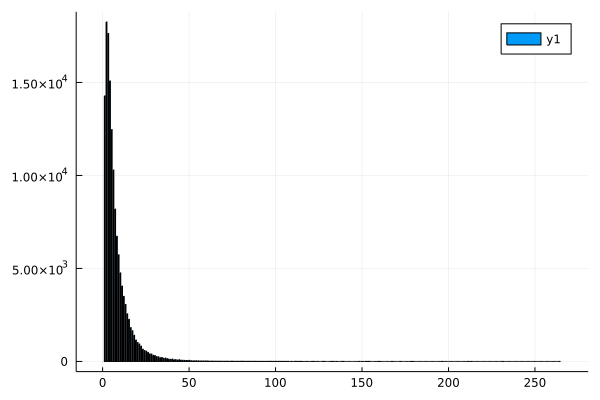

In [100]:
using Plots
histogram(n_measurements)